In [0]:
#@title initialized
import os
import scipy.io
import sys
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from IPython.display import clear_output
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf 
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Colab Notebooks/acoustic-articulatory'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#@title parameters

ExpNum = 1
threshold = 0.0
frame_context = 0

# ----------------------------Data parameters---------------------------------

Number_of_Files = 1
num_examples_per_epoch = 61155
FeaturesDimension = 39
n_targets = 21


# ---------------------------Network parameters--------------------------------------------
name_optimizer = 'momentum'

if name_optimizer not in ['adam', 'momentum', 'GD']:
    print('Optimizer not found.')
    print('Allowed choices : adam, momentum, GD.')
    sys.exit()

input_data = 'Audio'
learning_rate = 0.01
batch_size = 405
batch_size_v = 416

num_epochs = 40
n_nodes = 300
activation = tf.nn.relu
biases_initialization = 0.1

saveFileName='context-'+str(frame_context)+'-node-'+str(n_nodes)+'-layer-4'+'-lr-'+str(learning_rate)
saveFileName

'context-0-node-300-layer-4-lr-0.01'

In [0]:
#@title load data and split train validation set
# 
save_path_x = data_path + '/data/mfcc_contextSize-'+str(frame_context)+'.npy'
save_path_y = data_path + '/data/raw_ema.npy'

X = np.load(save_path_x).T
Y = np.load(save_path_y).T


# Split into training and testing data
train_features, valid_features, train_labels, valid_labels = train_test_split(X, Y, test_size = 0.3,random_state = 42)
valid_features = valid_features[2:,:]
valid_labels   = valid_labels[2:,:]

M = np.mean(train_features,axis=0)
N = np.std(train_features,axis=0)

train_features = (train_features-M)/N
valid_features = (valid_features-M)/N



M = np.mean(train_labels,axis=0)
N = np.std(train_labels,axis=0)

train_labels = (train_labels-M)/N
valid_labels = (valid_labels-M)/N


print('Train shape: ', train_features.shape)
print('Test shape: ', valid_features.shape)

Train shape:  (61155, 39)
Test shape:  (26208, 39)


In [0]:
#@title Saver directories
# 

data_dir = data_path + '/DATA/DNNs/' + input_data + '_NormalizedMotors_Ws' + str(frame_context) + '/'
checkpoints_dir = data_path + '/Results/DNNs/' + input_data + '2AFs/checkpoints/exp' \
                    + str(ExpNum) + '/'
tensorboard_dir = data_path + '/Results/DNNs/' + input_data + '2AFs/tensorboard/exp' + \
                    str(ExpNum) + '/'
traininglog_dir = data_path + '/Results/DNNs/' + input_data + '2AFs/training_logs/'

if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(traininglog_dir):
    os.makedirs(traininglog_dir)



In [0]:
#@title network structure
# 
def rmse(x, y):
    mse = mean_squared_error(x, y)
    return sqrt(mse)

def correlation(x, y):
    cm = np.corrcoef(x, y, rowvar=0)
    d = np.diagonal(cm, offset=x.shape[1])
    corr_mean = np.mean(d)
    return corr_mean

def inference(examples, input_dim, nodes, classes, act, biases_init):
    with tf.variable_scope('layer_1'):
        layer_1_weights = tf.get_variable('weights', [input_dim, nodes],
                                          initializer=tf.contrib.layers.xavier_initializer())
        layer_1_biases = tf.get_variable('biases', initializer=tf.constant(biases_init, shape=[nodes]))

        layer_1 = act(tf.add(tf.matmul(examples, layer_1_weights), layer_1_biases))

        tf.summary.histogram('weights', layer_1_weights)
        tf.summary.histogram('biases', layer_1_biases)
        tf.summary.histogram('activation', layer_1)

    with tf.variable_scope('layer_2'):
        layer_2_weights = tf.get_variable('weights', [nodes, nodes], initializer=tf.contrib.layers.xavier_initializer())
        layer_2_biases = tf.get_variable('biases', initializer=tf.constant(biases_init, shape=[nodes]))

        layer_2 = act(tf.add(tf.matmul(layer_1, layer_2_weights), layer_2_biases))

        tf.summary.histogram('weights', layer_2_weights)
        tf.summary.histogram('biases', layer_2_biases)
        tf.summary.histogram('activation', layer_2)

    with tf.variable_scope('layer_3'):
        layer_3_weights = tf.get_variable('weights', [nodes, nodes], initializer=tf.contrib.layers.xavier_initializer())
        layer_3_biases = tf.get_variable('biases', initializer=tf.constant(biases_init, shape=[nodes]))

        layer_3 = act(tf.add(tf.matmul(layer_2, layer_3_weights), layer_3_biases))

        tf.summary.histogram('weights', layer_3_weights)
        tf.summary.histogram('biases', layer_3_biases)
        tf.summary.histogram('activation', layer_3)

    with tf.variable_scope('layer_4'):
        layer_4_weights = tf.get_variable('weights', [nodes, nodes], initializer=tf.contrib.layers.xavier_initializer())
        layer_4_biases = tf.get_variable('biases', initializer=tf.constant(biases_init, shape=[nodes]))

        layer_4 = act(tf.add(tf.matmul(layer_3, layer_4_weights), layer_4_biases))

        tf.summary.histogram('weights', layer_4_weights)
        tf.summary.histogram('biases', layer_4_biases)
        tf.summary.histogram('activation', layer_4)

    with tf.variable_scope('output'):
        output_weights = tf.get_variable('weights', [nodes, classes],
                                         initializer=tf.contrib.layers.xavier_initializer())
        output_biases = tf.get_variable('biases', initializer=tf.constant(biases_init, shape=[classes]))
        output = tf.add(tf.matmul(layer_4, output_weights), output_biases)

        tf.summary.histogram('weights', output_weights)
        tf.summary.histogram('biases', output_biases)
        tf.summary.histogram('activation', output)

    return output

In [0]:
#@title traning
# 
def training_runner():
    A = []
    with tf.Graph().as_default():
        with tf.device('/cpu:0'):
            with tf.variable_scope('traning_variables'):
                traning_variables = tf.placeholder('float', [None, train_features.shape[1]], name='traning_variables')
                print('Placeholder initialized.')

            with tf.variable_scope('traning_variables_labels'):
                traning_variables_labels = tf.placeholder('float', [None, train_labels.shape[1]], name='traning_variables_labels')
                print('Placeholder initialized.')

            with tf.variable_scope('validation_variables'):
                validation_variables = tf.placeholder('float', [None, valid_features.shape[1]], name='validation_variables')
                print('Placeholder initialized.')

            with tf.variable_scope('validation_variables_labels'):
                validation_variables_labels = tf.placeholder('float', [None, valid_labels.shape[1]], name='validation_variables_labels')
                print('Placeholder initialized.')

        with tf.device('/gpu:0'):          
            with tf.variable_scope('training_graph') as train_scope:
                logits = inference(traning_variables, train_features.shape[1],
                                   n_nodes, n_targets, activation, biases_initialization)

                # COST FUNCTION:
                with tf.variable_scope('cost'):
                    cost = tf.reduce_mean(tf.squared_difference(logits, traning_variables_labels))
                    tf.summary.scalar('cost', cost)

                with tf.variable_scope('optimization'):
                    # METHOD OF MINIMIZATION:
                    if name_optimizer == 'adam':
                      optimizer = tf.train.AdamOptimizer().minimize(cost)
                    elif name_optimizer == 'momentum':
                      optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cost)
                    elif name_optimizer == 'GD':
                      optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

                with tf.name_scope('validation_graph'):
                    with tf.variable_scope(train_scope, reuse=True):
                        validation_logits = inference(validation_variables, valid_features.shape[1],
                                       n_nodes, n_targets, activation, biases_initialization)

                    


        # Merge summaries for tensorboard
        merged = tf.summary.merge_all()

        config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        config.gpu_options.allow_growth = True        

        # OPS to save and restore all the variables.
        saver = tf.train.Saver()

        # VARIABLES INITIALIZER
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())


        # Create a session for running operations in the Graph.
        with tf.Session(config=config) as sess:
            train_writer = tf.summary.FileWriter(tensorboard_dir, sess.graph)
            # Initialize all the variables (including the epoch counter, hidden somewhere).
            sess.run(init_op)

            ############### start TRAINING ##############
            for epoch in range(num_epochs):    

                ############### TRAINING ##############
                epoch_cost = 0.0
                permS = np.random.permutation(train_features.shape[0])
                counter = 0
                for iter in range(0,train_features.shape[0]-batch_size,batch_size):
                    batch_x= train_features[permS[iter:iter+batch_size],:]
                    batch_y= train_labels[permS[iter:iter+batch_size],:]
                    _, c=  sess.run([optimizer,cost],feed_dict={traning_variables: batch_x, traning_variables_labels:batch_y})
                    epoch_cost+=c
                    counter = counter +1
                epoch_cost = epoch_cost/counter

                ############## validation ##########################
                permSV = np.random.permutation(valid_features.shape[0])
                counter = 0
                corr_test = 0.0
                err_test = 0.0
                epoch_costV = 0
                for iter in range(0,valid_features.shape[0]-batch_size_v,batch_size_v):
                    batch_v_x= valid_features[permSV[iter:iter+batch_size_v],:]
                    batch_v_y= valid_labels[permSV[iter:iter+batch_size_v],:]

                    prediction =  sess.run(validation_logits,feed_dict={validation_variables: batch_v_x})
                    c = sess.run(tf.reduce_mean(tf.squared_difference(prediction, batch_v_y)))
                    epoch_costV+=c

                    err = rmse(prediction, batch_v_y)
                    err_test += err
                    corr = correlation(prediction, batch_v_y)
                    corr_test += corr
                    counter = counter +1
                epoch_costV = epoch_costV/counter
                corr_test = corr_test/counter
                err_test = err_test/counter





                train_loss = np.round(epoch_cost, decimals=4)
                validation_loss = np.round(epoch_costV, decimals=4)
                corr_test = np.round(corr_test, decimals=4)
                err_test = np.round(err_test, decimals=4)

                df = pd.DataFrame({'Epoch':[epoch+1],'train_loss':train_loss,'validation_loss':validation_loss,
                                   'corr':corr_test,'RMSE':err_test})
                A.append(df)

                print('Epoch',epoch+1,'/', num_epochs,'loss:',train_loss,' validation - loss:',
                      validation_loss,' corr:',corr_test,' rmse:',err_test)



              #summarize to tensorboard
              #summary = sess.run(merged)
              #train_writer.add_summary(summary, epoch)              
              #train_writer.flush()


            save_path = saver.save(sess, checkpoints_dir + 'model_end.ckpt')
            print("model saved in file: %s" % save_path)           


            ######################################################################################################
            # Print useful info and a log file   
            trainingLogFile = open(traininglog_dir + 'TrainingExperiment' + str(ExpNum) + '.txt', 'w')
            print('')
            print('## EXPERIMENT NUMBER ', ExpNum)
            trainingLogFile.write('# EXPERIMENT NUMBER {:d} \n'.format(ExpNum))
            print('## number of hidden layers : ', 5)
            trainingLogFile.write('## number of hidden layers : {:d} \n'.format(5))
            print('## number of neurons : ', n_nodes)
            trainingLogFile.write('## number of neurons : {:d} \n'.format(n_nodes))
            print('## window size : ', frame_context)
            trainingLogFile.write('## Ws : ' + str(frame_context))
            print('## optimizer : ' + name_optimizer)
            trainingLogFile.write('## optimizer : ' + name_optimizer + '\n')
            print('## learning rate: ' + str(learning_rate))
            trainingLogFile.write('## learning rate : ' + str(learning_rate) + '\n')
            print('## number of epochs : ', num_epochs)
            trainingLogFile.write('## number of epochs : {:d} \n'.format(num_epochs))
            print('## batch size : ', batch_size)
            trainingLogFile.write('## batch size : {:d} \n'.format(batch_size))
            print('## threshold early stopping : ', threshold)
            trainingLogFile.write('## Early stopping with threshold {:f} \n'.format(threshold))
            training_log_string = '{}\t{}\t{}\n'.format(frame_context, batch_size, num_epochs)
            trainingLogFile.write(training_log_string)
            trainingLogFile.close()
            ######################################################################################################

            
    A = pd.concat((A),axis=0)        
    return A   

In [0]:
df = training_runner()
clear_output()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


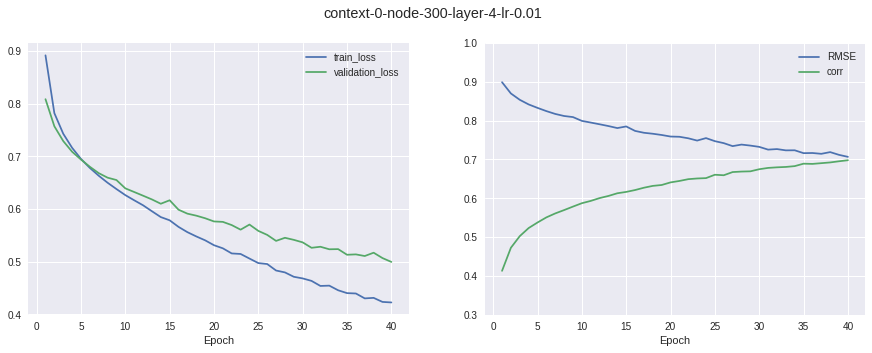

In [0]:
#@title plot and save files

f, axes = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
df.plot(x='Epoch',y=['train_loss','validation_loss'],ax=axes[0])
plt.ylim([0.1, 1])
df.plot(x='Epoch',y=['RMSE','corr'],ax=axes[1])
plt.ylim([0.3, 1])
plt.suptitle(saveFileName)

save_path = data_path + '/Results/DNNs/'+saveFileName
plt.savefig(save_path+'.png')
df.to_pickle(save_path+'.pkl')
